In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [2]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [3]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = []
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    lc_wind_nan = np.asarray(lc_wind_nan)   
    lengths = np.asarray(lengths)   

    print("Cantidad de tramos: ",len(lengths))
    print("Largo promedio de tramos: ", np.mean(lengths))
    print("Mediana de largo de tramos: ", np.median(lengths))
    print("Min de largo de tramos: ", np.min(lengths))
    print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

### Version normal

In [4]:
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return  np.concatenate([estados_up,estados_low])

def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    transition_m += 1 #priors
    transition_m = transition_m/transition_m.sum(axis=-1, keepdims=True)        
    return transition_m
                    

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [5]:
from numba import njit, jit
from numba.typed import List

In [6]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

########### no lo logre hacer funcionar
#@njit(parallel=True, cache=False, fastmath=True)
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [7]:
ests=det_state_2ways(1,-1, n_sta_up=10, n_sta_low=25) #20 estados en total

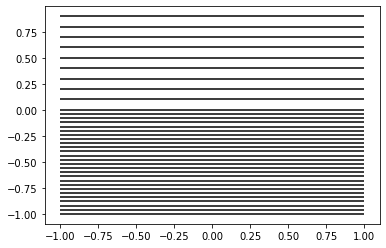

In [8]:
for lim in ests:
    plt.hlines(lim[1], -1,1)
plt.show()

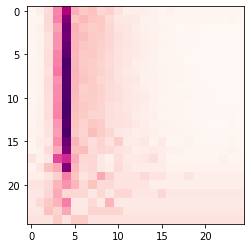

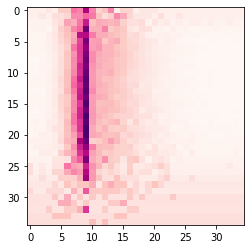

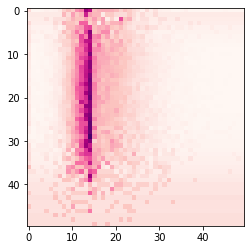

CPU times: user 672 ms, sys: 45.8 ms, total: 718 ms
Wall time: 652 ms


In [19]:
%%time
"""transition_m = manual_HMM(lc_tramos, n_sta_up=5, n_sta_low=20)
plt.imshow(transition_m, cmap='RdPu')
plt.show()

transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=25)
plt.imshow(transition_m, cmap='RdPu')
plt.show()"""
fluxs = our_process[1]
fluxs = prepare_lc(fluxs) #divide by min
lc_tramos =  extract_nans(fluxs) #extract nans
lc_tramos #lista de tramos...

transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=35)
plt.imshow(transition_m, cmap='RdPu')
plt.show()

### Comportamiento Falsos postiviso

In [30]:
matrices_fp=[]
matrices_conf=[]
for arriba in ups:
    for abajo in downs:
        print ("ARRIBA Y ABAJO", arriba,abajo)
        falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
        index_fp=list(falsos_pos.index)
        len(index_fp)

        our_detrends=our_process[index_fp]
        our_detrends.shape

        i=0
        for lc_our_detrend in our_detrends:   
            print ("recuperando curva",i+1)
            fluxs = prepare_lc(lc_our_detrend) #divide by min
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans

            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...

            i+=1
            #plt.imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
            #plt.show()
            matrices_fp.append(transition_m)

ARRIBA Y ABAJO 5 10
recuperando curva 1
recuperando curva 2
recuperando curva 3
recuperando curva 4
recuperando curva 5
recuperando curva 6
recuperando curva 7
recuperando curva 8
recuperando curva 9
recuperando curva 10
recuperando curva 11
recuperando curva 12
recuperando curva 13
recuperando curva 14
recuperando curva 15
recuperando curva 16
recuperando curva 17
recuperando curva 18
recuperando curva 19
recuperando curva 20
recuperando curva 21
recuperando curva 22
recuperando curva 23
recuperando curva 24
recuperando curva 25
recuperando curva 26
recuperando curva 27
recuperando curva 28
recuperando curva 29
recuperando curva 30
recuperando curva 31
recuperando curva 32
recuperando curva 33
recuperando curva 34
recuperando curva 35
recuperando curva 36
recuperando curva 37
recuperando curva 38
recuperando curva 39
recuperando curva 40
recuperando curva 41
recuperando curva 42
recuperando curva 43
recuperando curva 44
recuperando curva 45
recuperando curva 46
recuperando curva 47
re

KeyboardInterrupt: 

### Comportamiento Confirmados

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


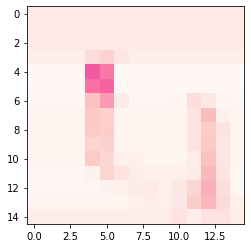

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


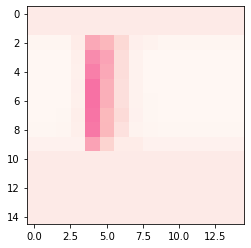

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


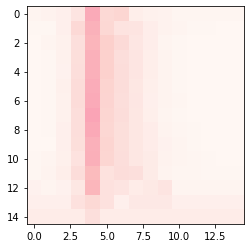

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


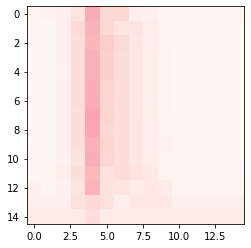

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


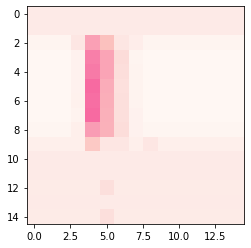

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


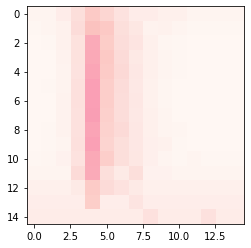

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


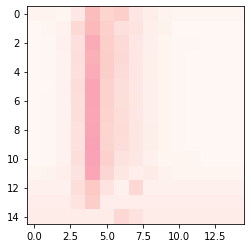

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


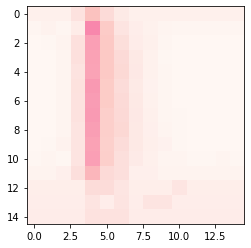

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


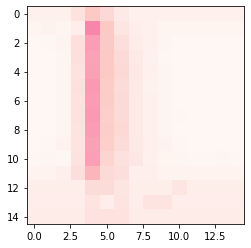

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


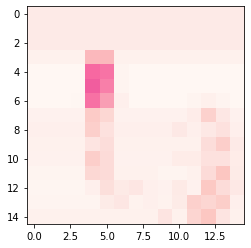

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


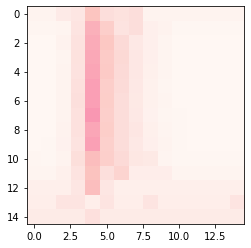

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


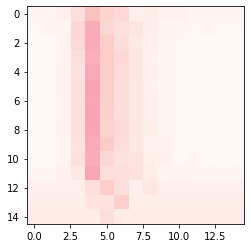

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


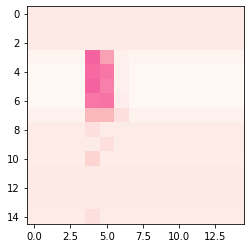

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


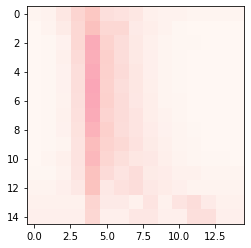

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


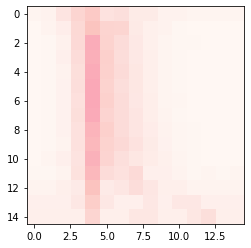

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


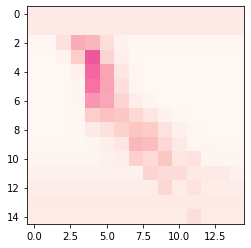

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


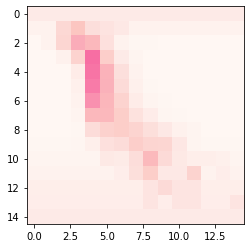

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


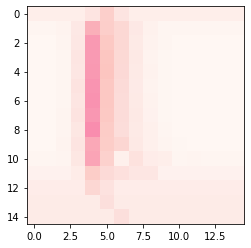

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


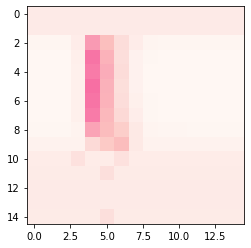

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


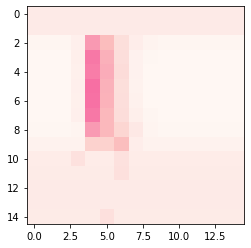

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


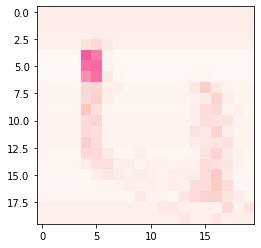

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


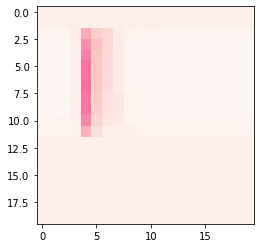

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


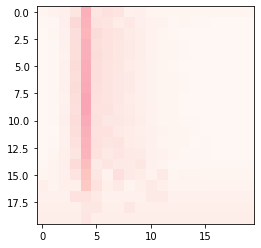

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


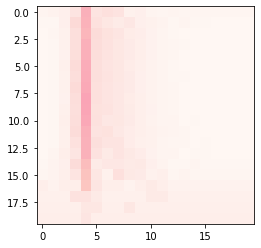

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


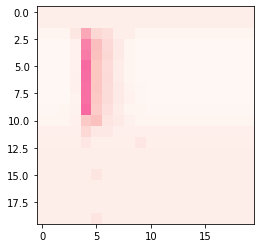

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


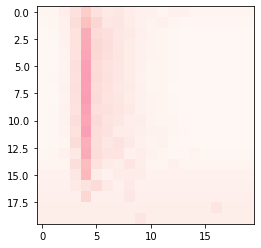

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


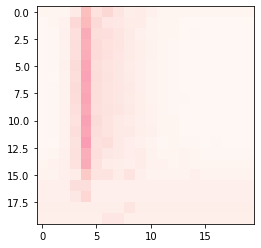

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


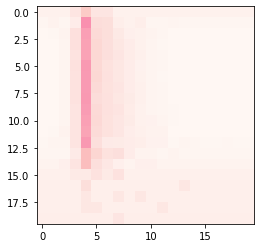

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


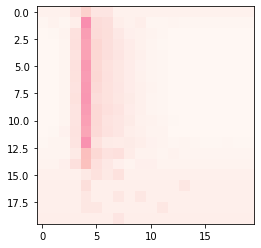

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


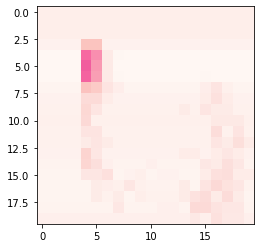

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


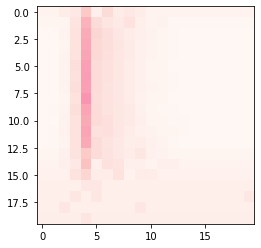

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


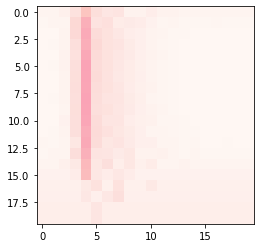

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


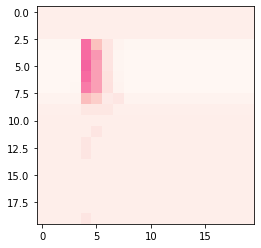

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


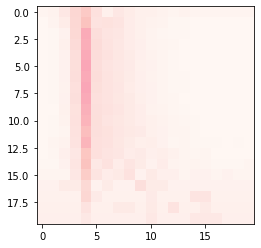

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


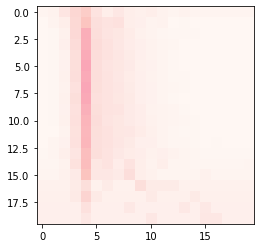

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


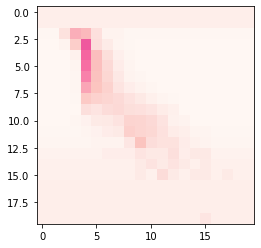

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


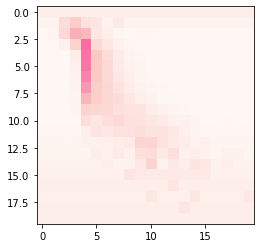

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


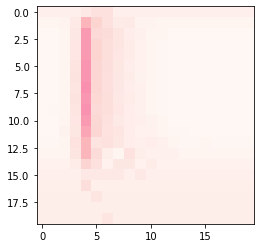

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


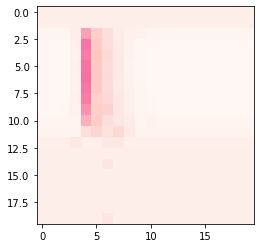

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


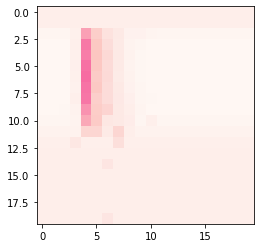

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


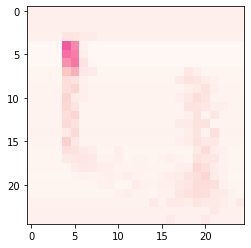

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


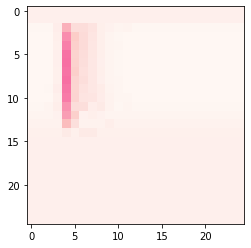

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


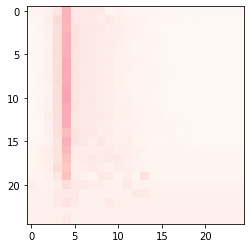

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


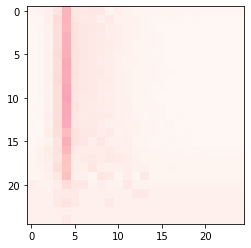

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


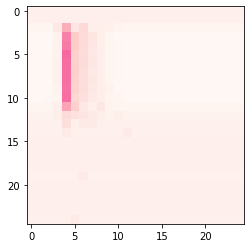

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


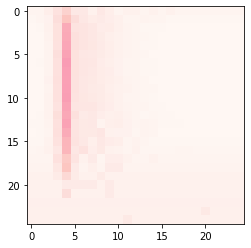

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


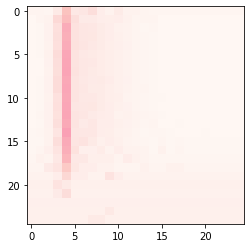

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


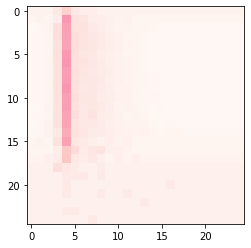

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


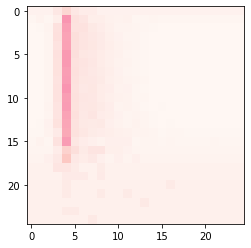

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


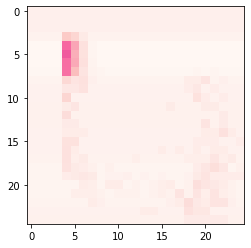

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


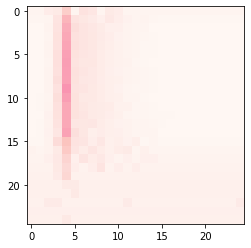

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


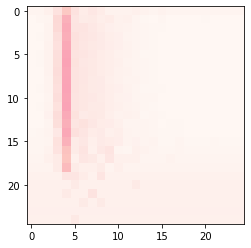

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


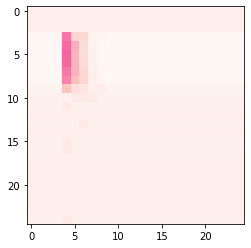

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


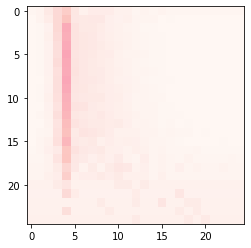

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


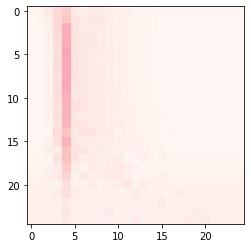

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


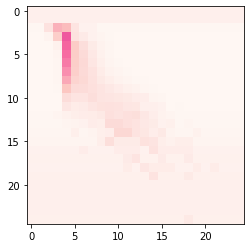

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


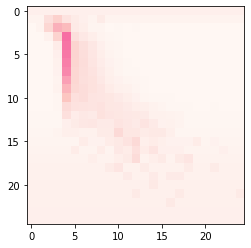

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


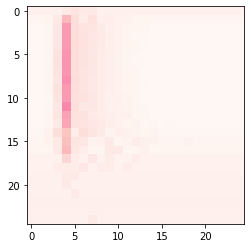

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


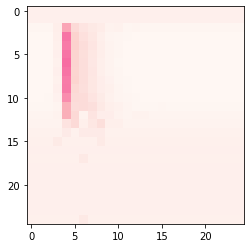

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


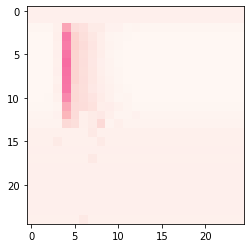

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


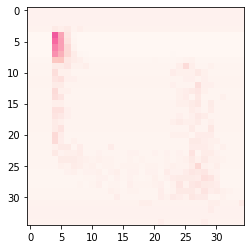

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


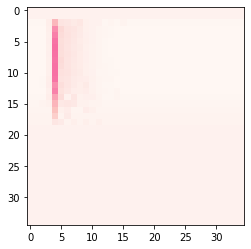

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


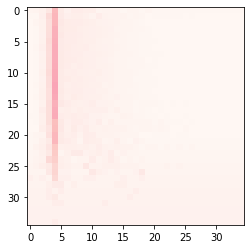

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


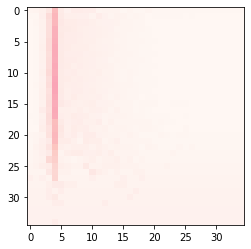

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


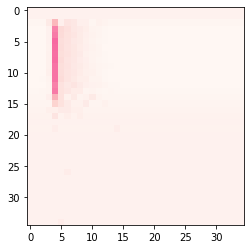

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


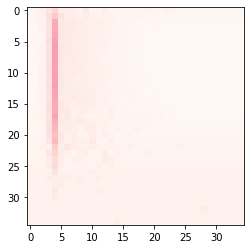

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


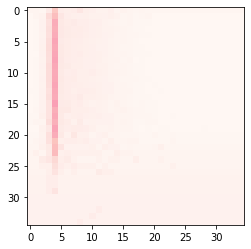

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


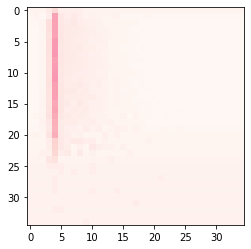

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


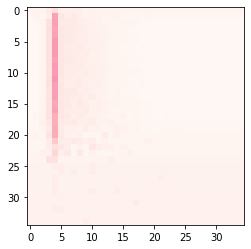

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


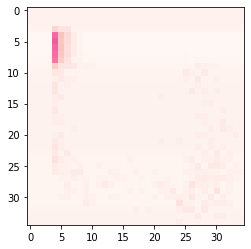

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


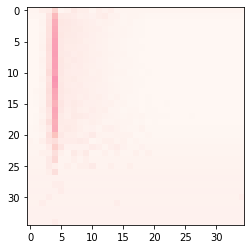

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


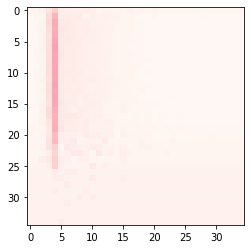

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


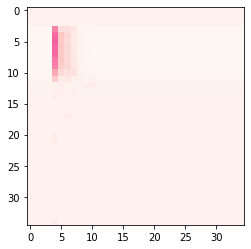

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


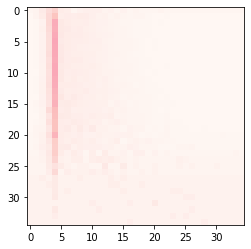

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


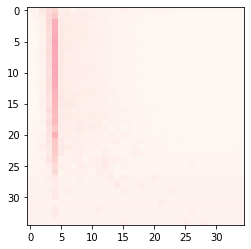

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


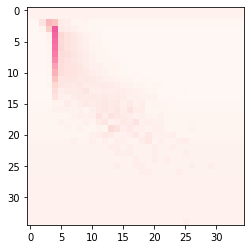

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


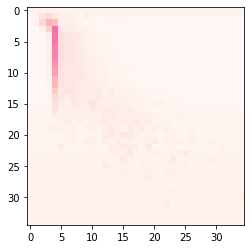

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


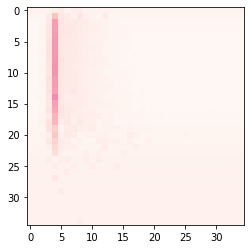

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


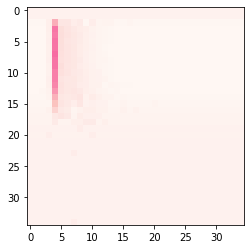

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


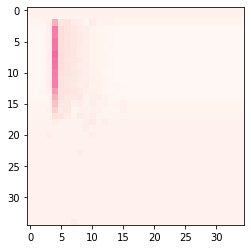

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


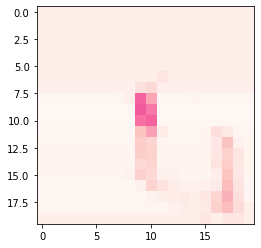

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


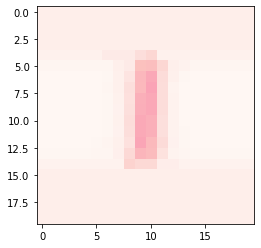

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


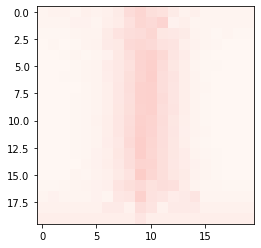

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


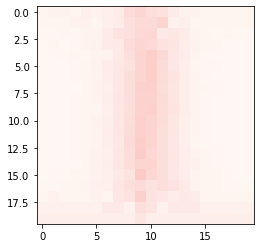

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


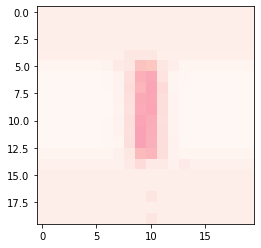

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


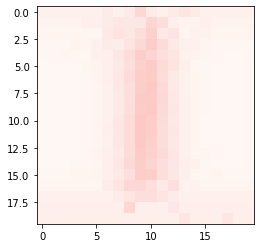

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


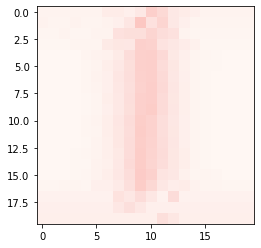

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


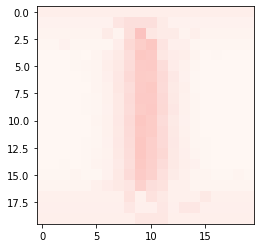

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


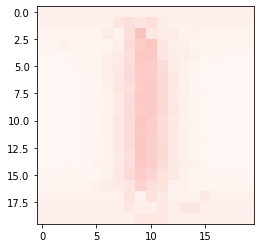

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


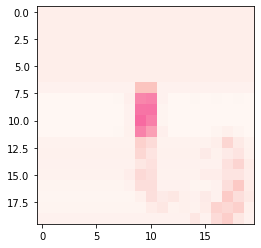

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


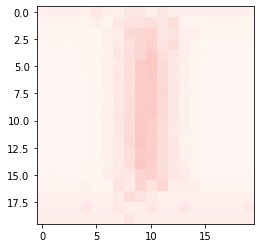

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


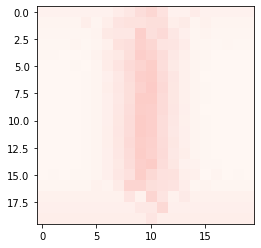

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


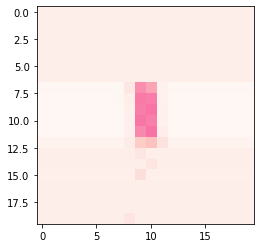

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


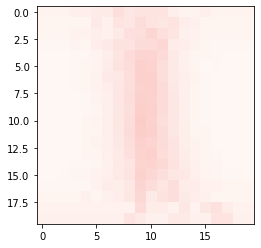

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


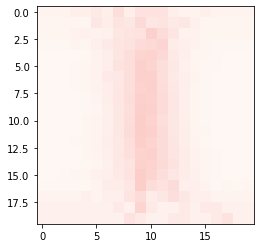

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


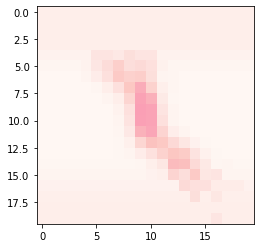

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


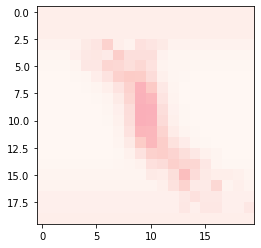

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


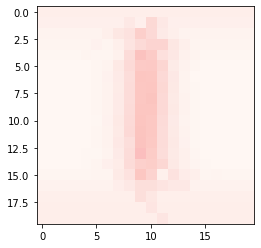

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


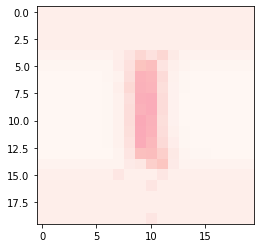

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


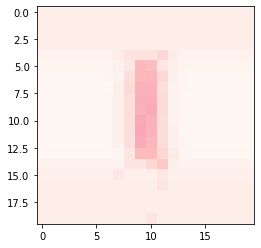

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


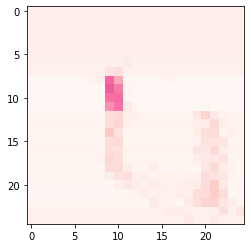

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


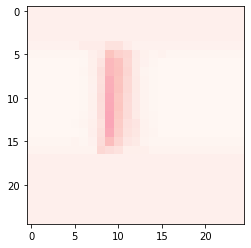

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


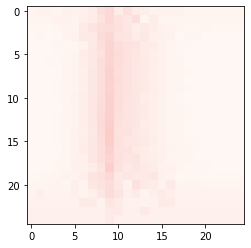

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


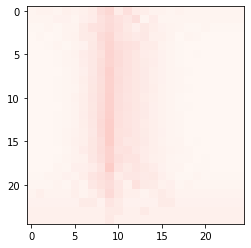

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


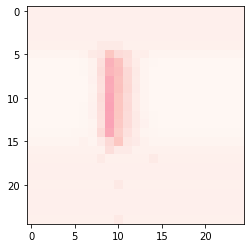

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


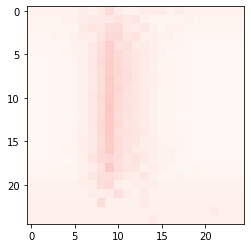

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


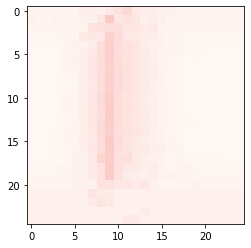

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


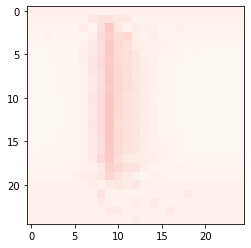

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


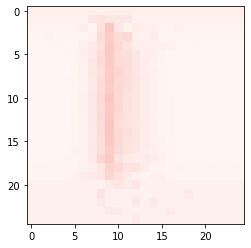

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


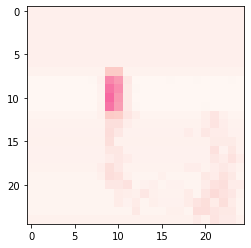

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


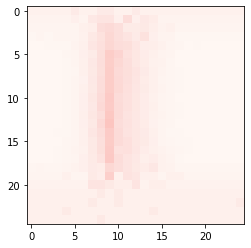

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


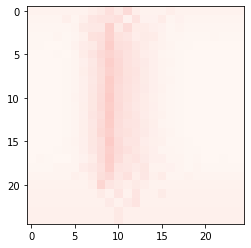

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


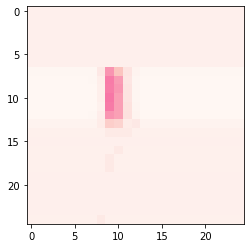

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


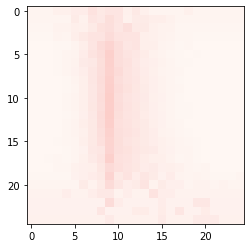

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


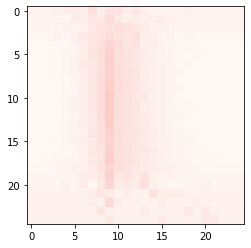

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


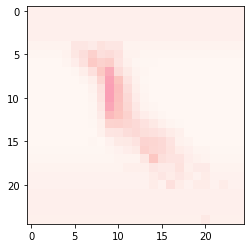

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


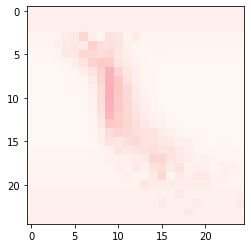

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


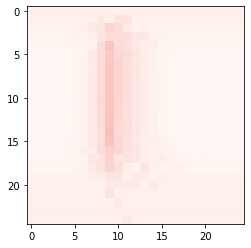

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


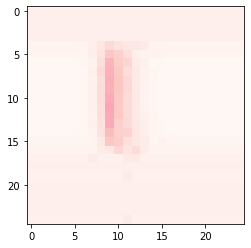

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


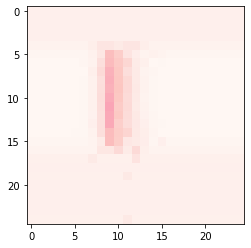

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


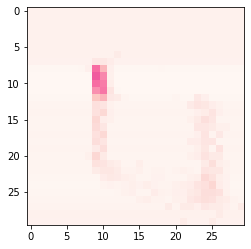

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


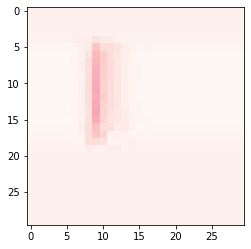

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


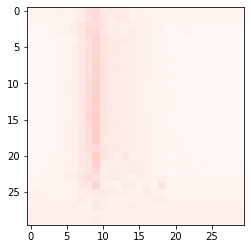

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


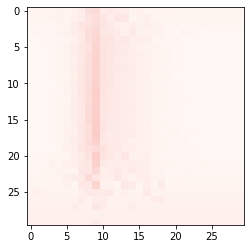

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


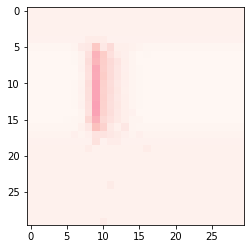

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


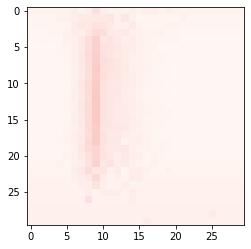

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


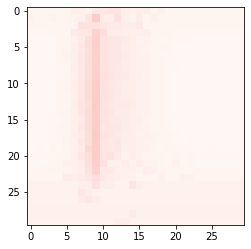

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


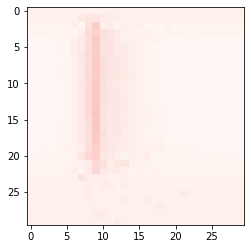

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


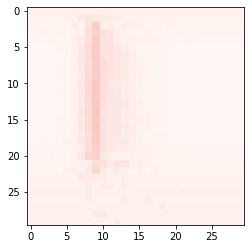

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


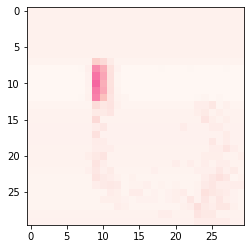

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


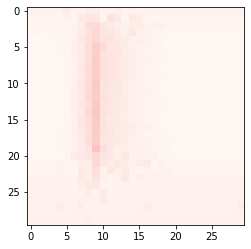

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


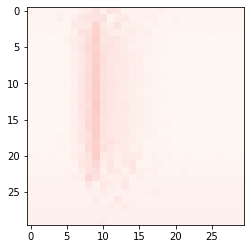

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


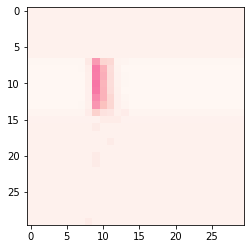

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


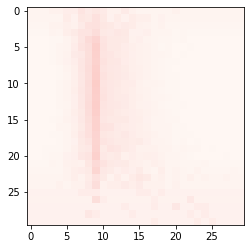

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


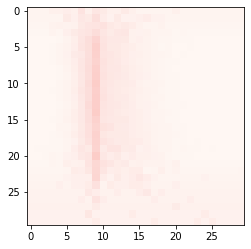

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


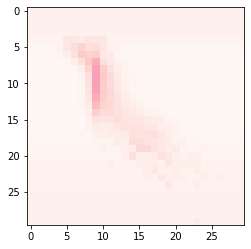

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


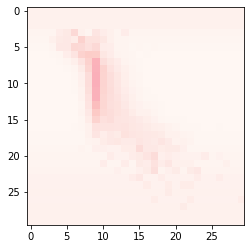

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


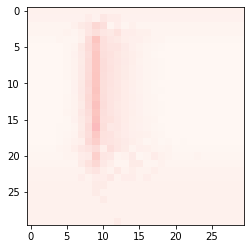

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


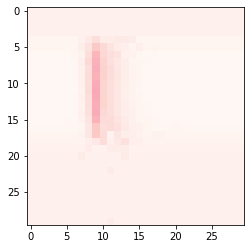

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


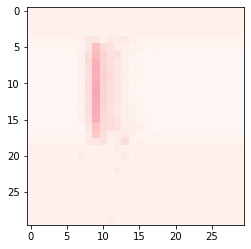

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


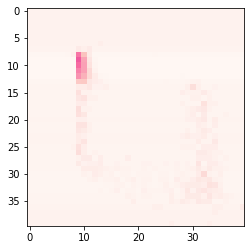

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


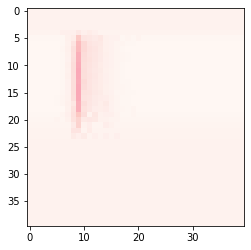

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


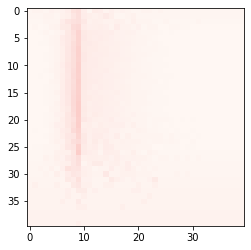

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


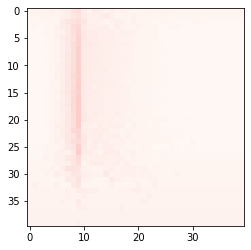

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


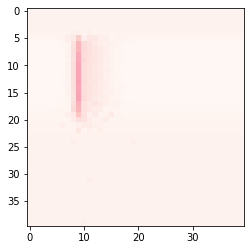

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


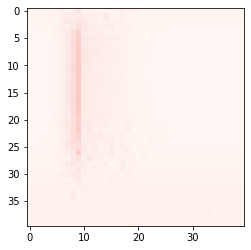

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


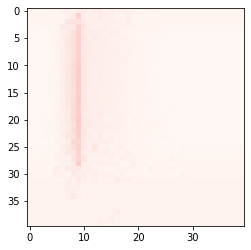

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


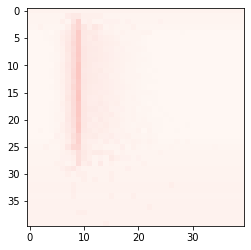

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


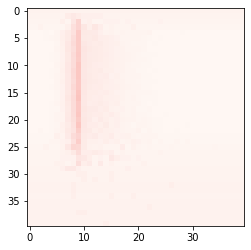

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


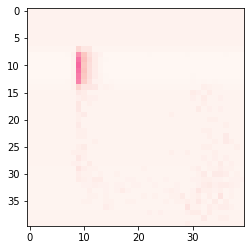

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


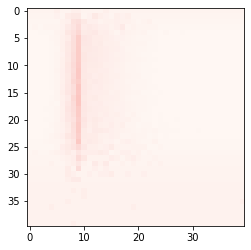

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


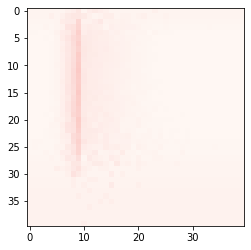

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


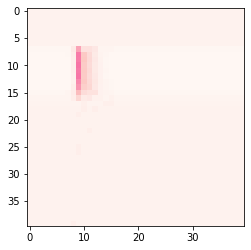

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


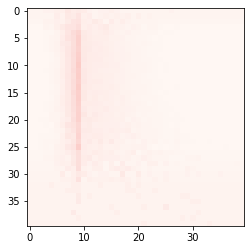

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


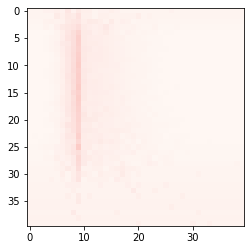

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


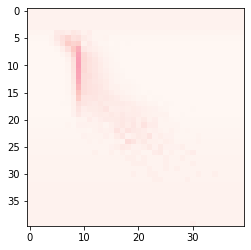

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


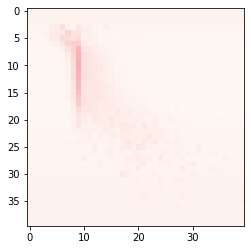

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


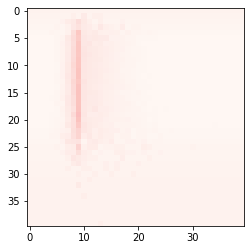

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


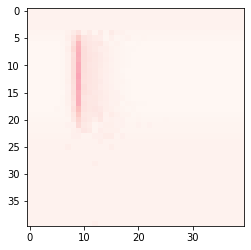

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


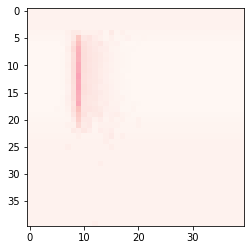

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


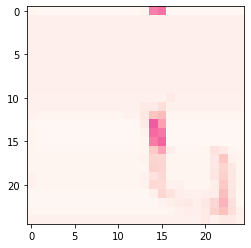

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


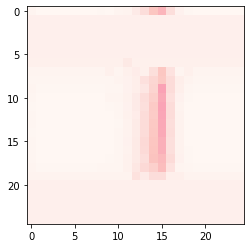

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


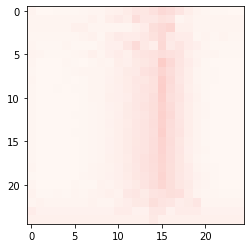

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


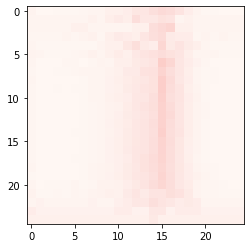

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


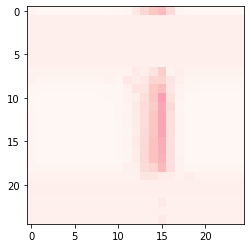

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


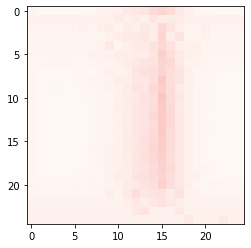

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


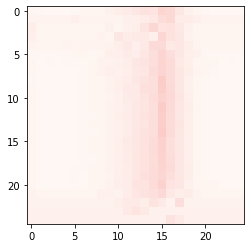

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


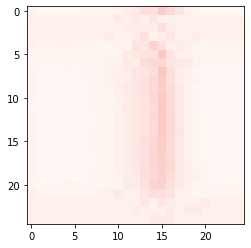

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


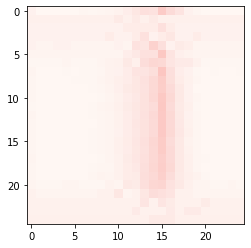

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


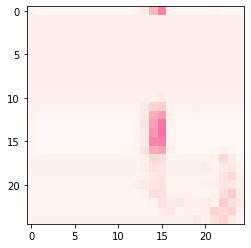

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


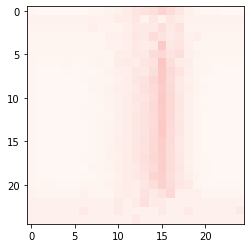

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


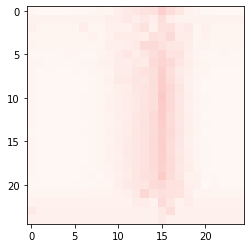

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


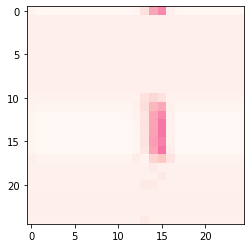

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


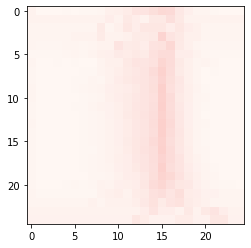

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


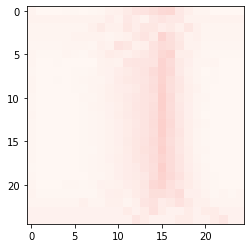

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


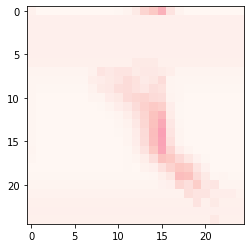

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


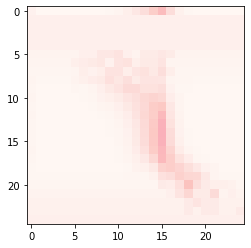

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


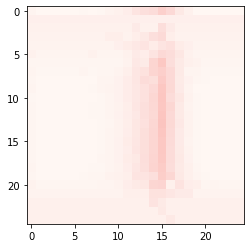

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


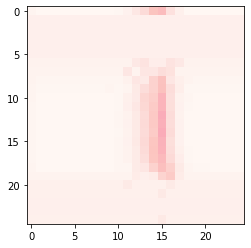

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


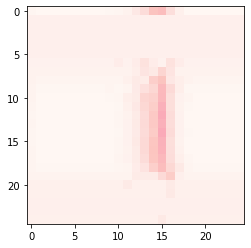

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


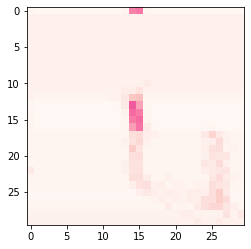

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


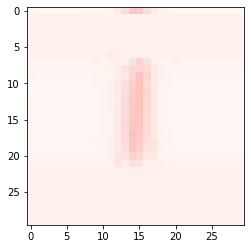

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


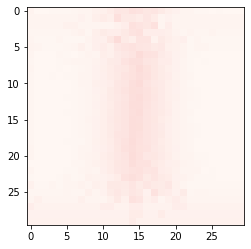

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


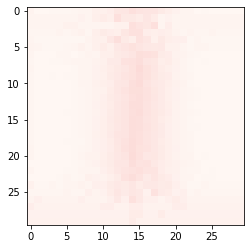

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


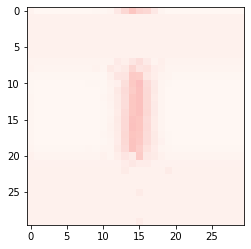

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


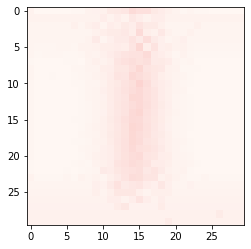

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


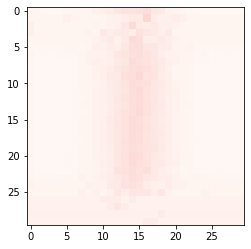

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


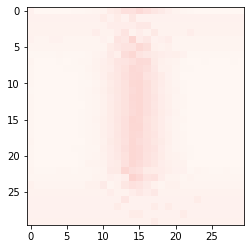

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


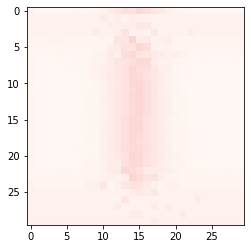

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


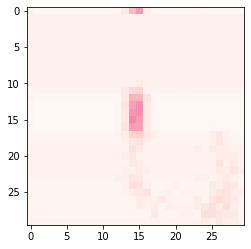

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


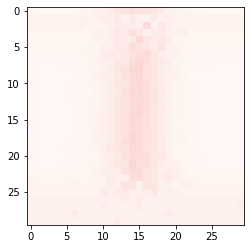

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


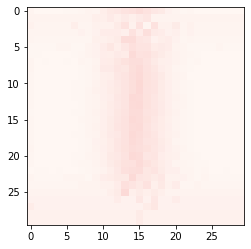

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


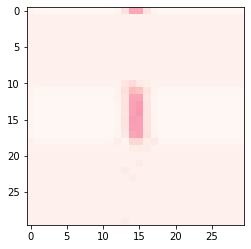

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


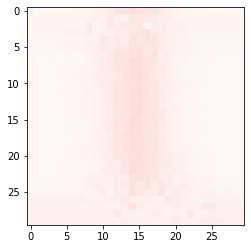

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


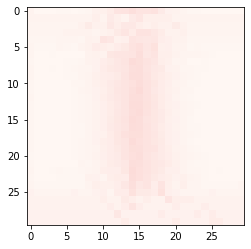

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


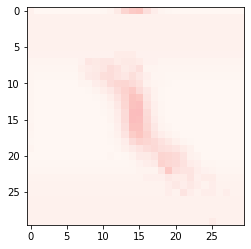

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


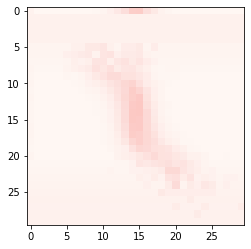

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


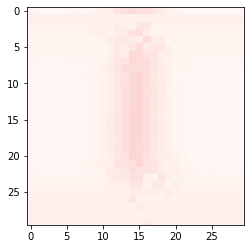

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


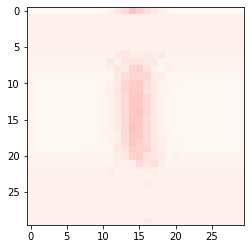

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


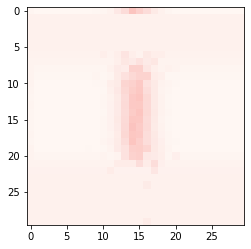

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


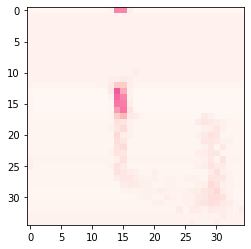

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


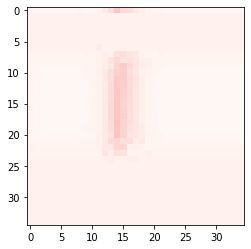

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


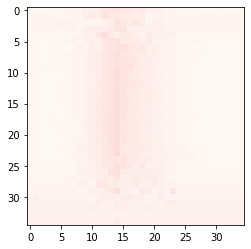

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


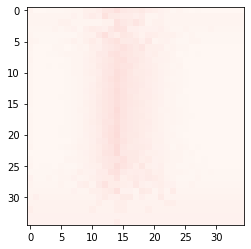

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


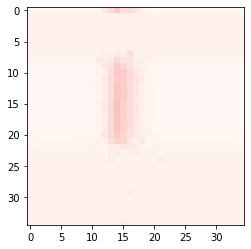

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


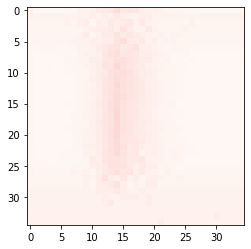

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


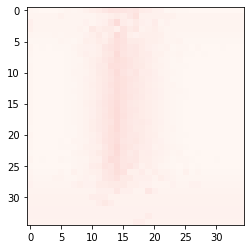

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


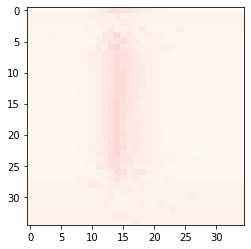

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


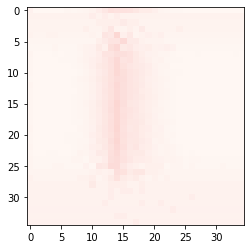

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


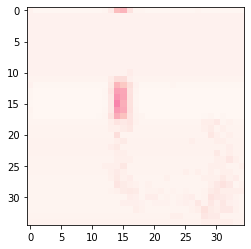

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


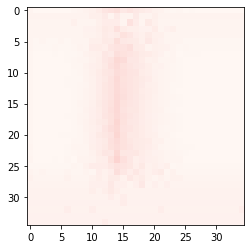

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


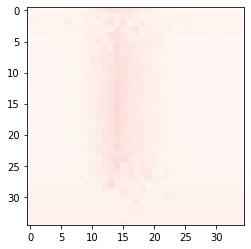

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


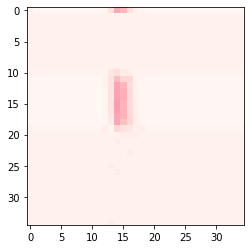

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


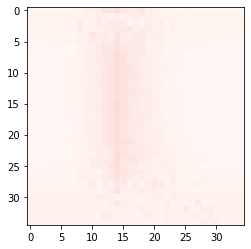

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


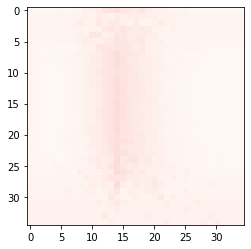

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


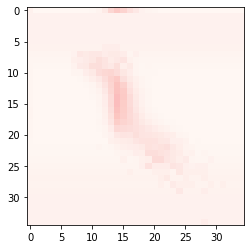

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


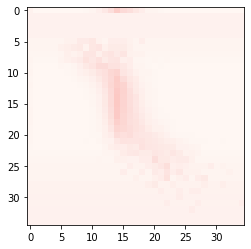

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


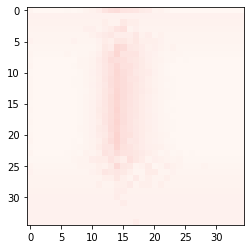

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


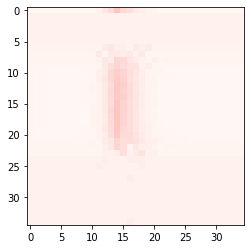

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


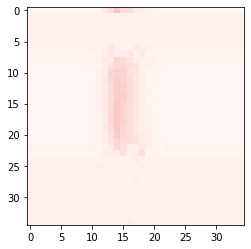

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


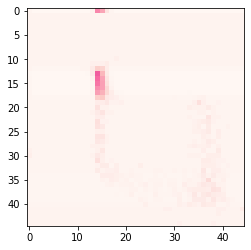

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


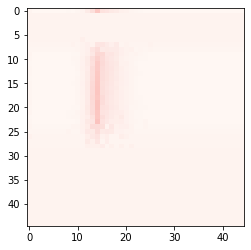

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


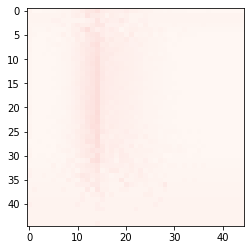

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


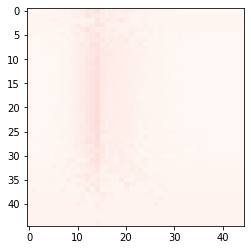

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


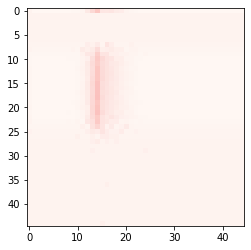

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


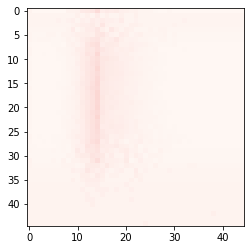

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


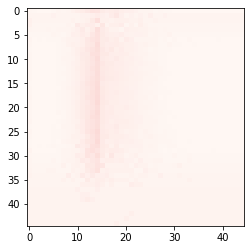

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


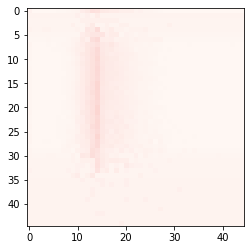

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


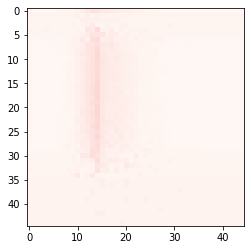

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


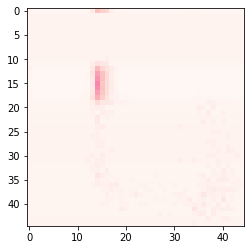

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


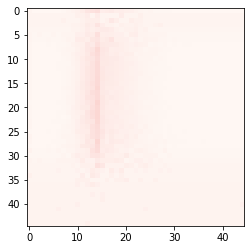

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


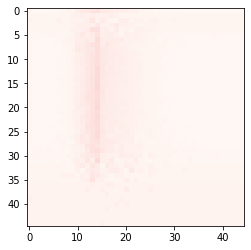

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


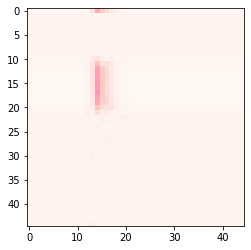

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


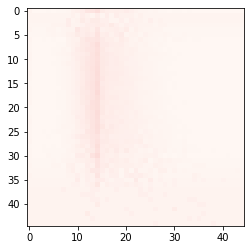

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


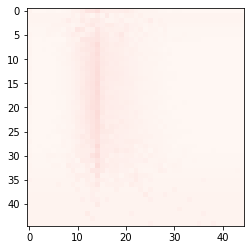

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


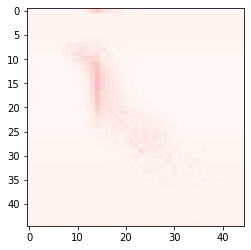

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


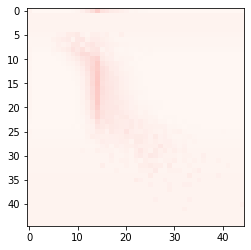

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


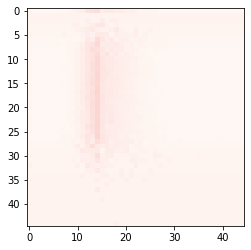

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


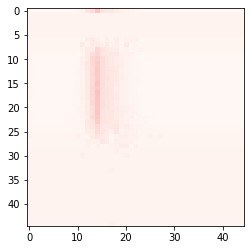

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


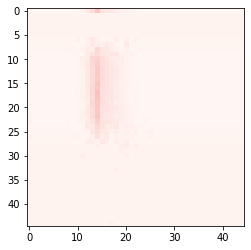

In [28]:
for arriba in ups:
    for abajo in downs:
        confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
        index_con=list(confirmados.index)
        our_detrends=our_process[index_con]
        len(index_con)
        i=0
        for lc_our_detrend in our_detrends[:20]:   
            print ("recuperando curva",i+1)
            fluxs = prepare_lc(lc_our_detrend) #divide by min
            lc_tramos =  extract_nans(fluxs) #extract nans

            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...

            i+=1
            plt.imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
            plt.show()

In [29]:
ups=[5,10,15]
downs=[10,15,20,30]

In [35]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process:   
            #print ("recuperando curva",i+1)
            fluxs = prepare_lc(lc_our_detrend) #divide by min
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans

            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...

            i+=1
            matrices.append(transition_m)
        matrices = np.asarray(matrices)
        
        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 5 10
Creada la configuracion
ARRIBA Y ABAJO 5 15
Creada la configuracion
ARRIBA Y ABAJO 5 20
Creada la configuracion
ARRIBA Y ABAJO 5 30
Creada la configuracion
ARRIBA Y ABAJO 10 10
Creada la configuracion
ARRIBA Y ABAJO 10 15
Creada la configuracion
ARRIBA Y ABAJO 10 20
Creada la configuracion
ARRIBA Y ABAJO 10 30
Creada la configuracion
ARRIBA Y ABAJO 15 10
Creada la configuracion
ARRIBA Y ABAJO 15 15
Creada la configuracion
ARRIBA Y ABAJO 15 20
Creada la configuracion
ARRIBA Y ABAJO 15 30
Creada la configuracion


### En sentido contrario! 

In [30]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO INVERTIDO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process:   
            fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans

            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...

            i+=1
            matrices.append(transition_m)
        matrices = np.asarray(matrices)
        
        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO INVERTIDO 5 10
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 5 15
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 5 20
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 5 30
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 10 10
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 10 15
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 10 20
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 10 30
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 15 10
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 15 15
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 15 20
Creada la configuracion
ARRIBA Y ABAJO INVERTIDO 15 30
Creada la configuracion
